# Importer les librairies

In [1]:
! pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
pd.set_option("display.max_columns",200)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from category_encoders import TargetEncoder

# Lire les données

In [3]:
data_dpt = pd.read_csv("dpt2022.csv", sep = ";")
data_dpt.head(10)

,sexe,preusuel,annais,dpt,nombre
0,1,_PRENOMS_RARES,1900,02,7
1,1,_PRENOMS_RARES,1900,04,9
2,1,_PRENOMS_RARES,1900,05,8
3,1,_PRENOMS_RARES,1900,06,23
4,1,_PRENOMS_RARES,1900,07,9
5,1,_PRENOMS_RARES,1900,08,4
6,1,_PRENOMS_RARES,1900,09,6
7,1,_PRENOMS_RARES,1900,10,3
8,1,_PRENOMS_RARES,1900,11,11
9,1,_PRENOMS_RARES,1900,12,7


In [4]:
data_dpt[data_dpt['preusuel'] == 'CLAUDE']

,sexe,preusuel,annais,dpt,nombre
321761,1,CLAUDE,1900,01,41
321762,1,CLAUDE,1900,03,44
321763,1,CLAUDE,1900,13,12
321764,1,CLAUDE,1900,17,4
321765,1,CLAUDE,1900,21,9
...,...,...,...,...,...
2248729,2,CLAUDE,1987,972,5
2248730,2,CLAUDE,1990,972,4
2248731,2,CLAUDE,1992,75,3
2248732,2,CLAUDE,1998,972,3


# EDA - avant le nettoyage de données

## Taille de données

In [5]:
data_dpt.shape

(3835767, 5)

## Nombre de prénoms uniques

In [6]:
data_dpt["preusuel"].nunique()

36963

In [7]:
data_dpt["dpt"].unique()

array(['02', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
       '16', '17', '18', '19', '20', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '37', '38', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '50', '51', '53', '54', '56', '57',
       '58', '59', '60', '62', '63', '64', '65', '66', '67', '68', '69',
       '70', '71', '73', '74', '75', '76', '78', '79', '80', '81', '82',
       '83', '84', '85', '86', '88', '89', '971', '972', '973', '974',
       '03', '14', '15', '22', '35', '39', '49', '52', '61', '72', '77',
       '87', '01', '55', '36', '23', '21', '90', '91', '92', '93', '94',
       '95', '976', 'XX'], dtype=object)

## Top 10 prénoms populaires

In [7]:
data_dpt["preusuel"].value_counts().head(10)

preusuel
_PRENOMS_RARES    22451
CAMILLE           14151
MARIE             13432
PIERRE            11490
PAUL              10899
JEAN              10820
CLAUDE            10573
LOUIS             10319
ANTOINE           10015
FRANÇOIS          10000
Name: count, dtype: int64

## Statistiques résumées

In [8]:
data_dpt.describe(include = "all")

,sexe,preusuel,annais,dpt,nombre
count,3.835767e+06,3835766,3835767,3835767,3.835767e+06
unique,NaN,36963,124,101,NaN
top,NaN,_PRENOMS_RARES,2010,75,NaN
freq,NaN,22451,54905,131216,NaN
mean,1.534903e+00,NaN,NaN,NaN,2.298113e+01
std,4.987804e-01,NaN,NaN,NaN,8.056620e+01
min,1.000000e+00,NaN,NaN,NaN,3.000000e+00
25%,1.000000e+00,NaN,NaN,NaN,4.000000e+00
50%,2.000000e+00,NaN,NaN,NaN,7.000000e+00
75%,2.000000e+00,NaN,NaN,NaN,1.800000e+01


## Infos sur les données

In [9]:
data_dpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3835767 entries, 0 to 3835766
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   sexe      int64 
 1   preusuel  object
 2   annais    object
 3   dpt       object
 4   nombre    int64 
dtypes: int64(2), object(3)
memory usage: 146.3+ MB


## Données manquantes

In [8]:
data_dpt.isna().sum()

sexe        0
preusuel    1
annais      0
dpt         0
nombre      0
dtype: int64

In [9]:
data_dpt.isnull().sum()

sexe        0
preusuel    1
annais      0
dpt         0
nombre      0
dtype: int64

## Valeurs dupliquées

In [10]:
data_dpt.duplicated().sum()

0

## La variable "annais"

### Dataframe des valeurs non numériques

In [11]:
non_numeric_values_annais = data_dpt[~data_dpt["annais"].str.isnumeric()]
print(non_numeric_values_annais)

         sexe        preusuel annais dpt  nombre
11088       1  _PRENOMS_RARES   XXXX  XX    1063
11089       1               A   XXXX  XX      27
11090       1           AADAM   XXXX  XX      36
11091       1           AADEL   XXXX  XX      57
11094       1           AADIL   XXXX  XX     185
...       ...             ...    ...  ..     ...
3835747     2            ZURI   XXXX  XX      20
3835754     2         ZUZANNA   XXXX  XX     130
3835763     2             ZYA   XXXX  XX     290
3835765     2            ZYNA   XXXX  XX      74
3835766     2           ZYNEB   XXXX  XX     129

[39333 rows x 5 columns]


### Transformer les valeurs non numérique vers numérique

In [12]:
data_dpt["annais"] = pd.to_numeric(data_dpt["annais"], errors='coerce')

### Création de nouvelle variable "age"

In [13]:
import datetime
current_year = datetime.datetime.now().year
data_dpt["age"] = data_dpt["annais"].apply(lambda x: current_year - x)
data_dpt.head(10)

,sexe,preusuel,annais,dpt,nombre,age
0,1,_PRENOMS_RARES,1900.0,02,7,125.0
1,1,_PRENOMS_RARES,1900.0,04,9,125.0
2,1,_PRENOMS_RARES,1900.0,05,8,125.0
3,1,_PRENOMS_RARES,1900.0,06,23,125.0
4,1,_PRENOMS_RARES,1900.0,07,9,125.0
5,1,_PRENOMS_RARES,1900.0,08,4,125.0
6,1,_PRENOMS_RARES,1900.0,09,6,125.0
7,1,_PRENOMS_RARES,1900.0,10,3,125.0
8,1,_PRENOMS_RARES,1900.0,11,11,125.0
9,1,_PRENOMS_RARES,1900.0,12,7,125.0


In [14]:
data_dpt["age"].describe()

count    3.796434e+06
mean     5.029098e+01
std      3.439228e+01
min      3.000000e+00
25%      2.100000e+01
50%      4.300000e+01
75%      7.600000e+01
max      1.250000e+02
Name: age, dtype: float64

### Création de la variable "age_range"

In [15]:
def age_range(age):
  if age <= 20:
    return '0-20'
  elif age <= 42:
    return '21-42'
  elif age <= 65:
    return '43-65'
  elif age <= 80:
    return '66-80'
  else:
    return '80+'

In [16]:
data_dpt["age_range"] = data_dpt["age"].apply(age_range)
data_dpt.head(10)

,sexe,preusuel,annais,dpt,nombre,age,age_range
0,1,_PRENOMS_RARES,1900.0,02,7,125.0,80+
1,1,_PRENOMS_RARES,1900.0,04,9,125.0,80+
2,1,_PRENOMS_RARES,1900.0,05,8,125.0,80+
3,1,_PRENOMS_RARES,1900.0,06,23,125.0,80+
4,1,_PRENOMS_RARES,1900.0,07,9,125.0,80+
5,1,_PRENOMS_RARES,1900.0,08,4,125.0,80+
6,1,_PRENOMS_RARES,1900.0,09,6,125.0,80+
7,1,_PRENOMS_RARES,1900.0,10,3,125.0,80+
8,1,_PRENOMS_RARES,1900.0,11,11,125.0,80+
9,1,_PRENOMS_RARES,1900.0,12,7,125.0,80+


In [17]:
data_dpt["annais"].describe()

count    3.796434e+06
mean     1.974709e+03
std      3.439228e+01
min      1.900000e+03
25%      1.949000e+03
50%      1.982000e+03
75%      2.004000e+03
max      2.022000e+03
Name: annais, dtype: float64

## Type de données après la transformation de "annais" et la création de la variable "age" et "age_range"

In [18]:
data_dpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3835767 entries, 0 to 3835766
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   sexe       int64  
 1   preusuel   object 
 2   annais     float64
 3   dpt        object 
 4   nombre     int64  
 5   age        float64
 6   age_range  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 204.9+ MB


## Distribution des variables numériques

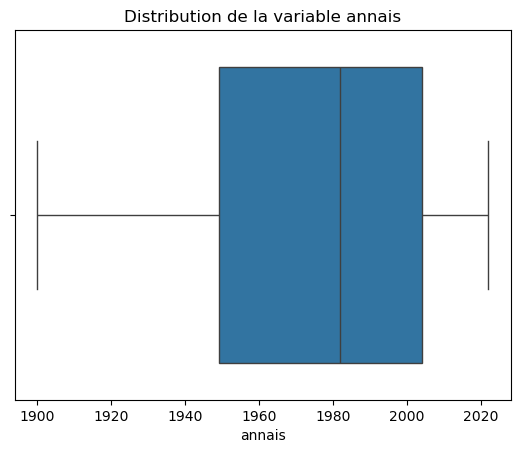

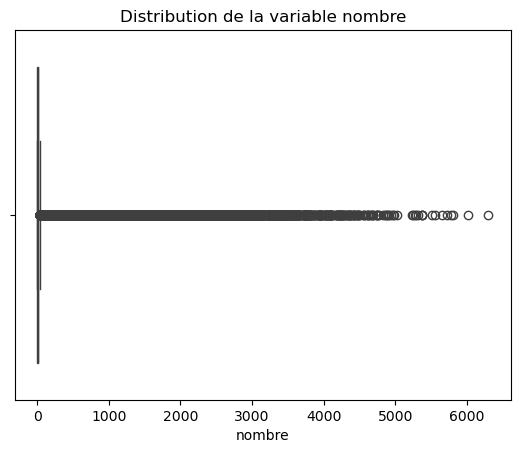

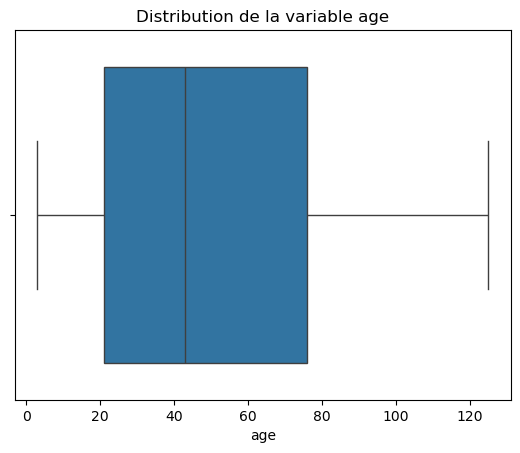

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in data_dpt.select_dtypes(include = "number").columns:
    if i == "sexe":
        continue
    sns.boxplot(data = data_dpt, x = i)
    # sns.histplot(data = train_data, x = i)
    plt.title(f"Distribution de la variable {i}")
    plt.show()

## Distribution de la variable "sexe"

C:\Users\NSP-PC\AppData\Local\Temp\ipykernel_10996\3272723801.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sexe', data=data_dpt, palette=['#3498db', '#e74c3c'])


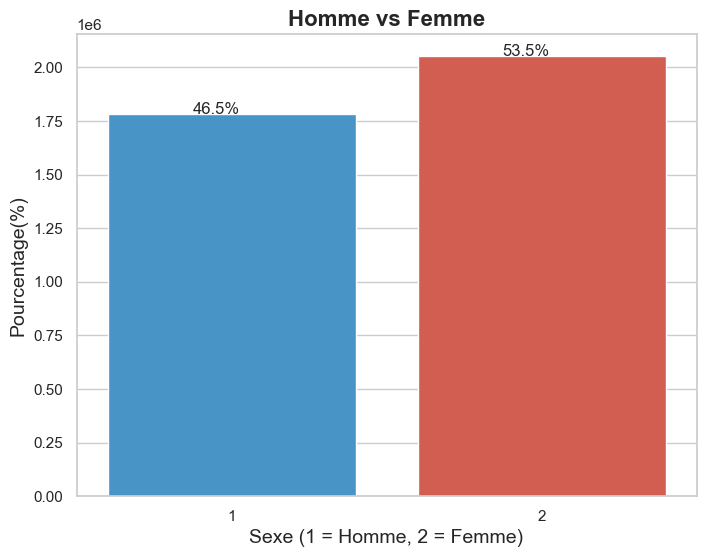

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sexe', data=data_dpt, palette=['#3498db', '#e74c3c'])
total = len(data_dpt)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.title('Homme vs Femme', fontsize=16, fontweight='bold')
plt.xlabel('Sexe (1 = Homme, 2 = Femme)', fontsize=14)
plt.ylabel('Pourcentage(%)', fontsize=14)
plt.savefig('sexe_distribution.png')
plt.show()

C:\Users\NSP-PC\AppData\Local\Temp\ipykernel_10996\3042313238.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='sexe', y='annais', data=data_dpt, palette=['#3498db', '#e74c3c'])


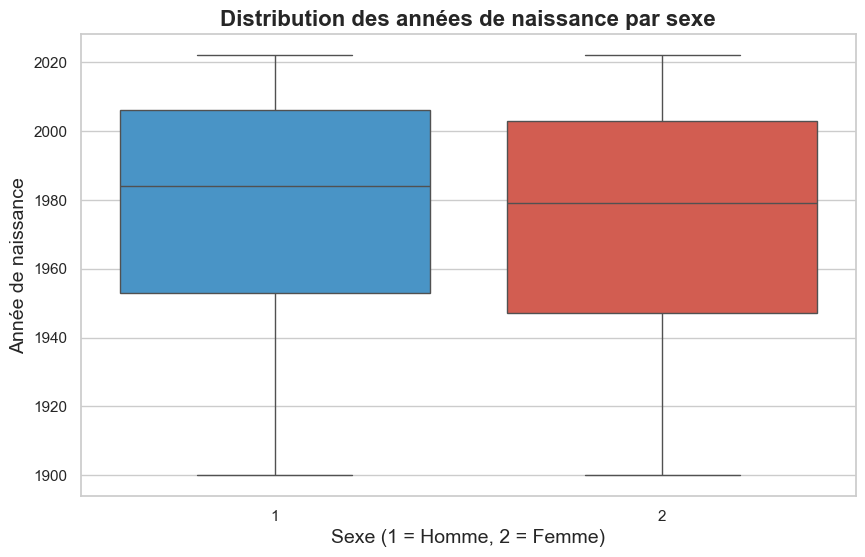

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='sexe', y='annais', data=data_dpt, palette=['#3498db', '#e74c3c'])

plt.title('Distribution des années de naissance par sexe', fontsize=16, fontweight='bold')
plt.xlabel('Sexe (1 = Homme, 2 = Femme)', fontsize=14)
plt.ylabel('Année de naissance', fontsize=14)
plt.savefig('annais_distribution_par_sexe.png')
plt.show()

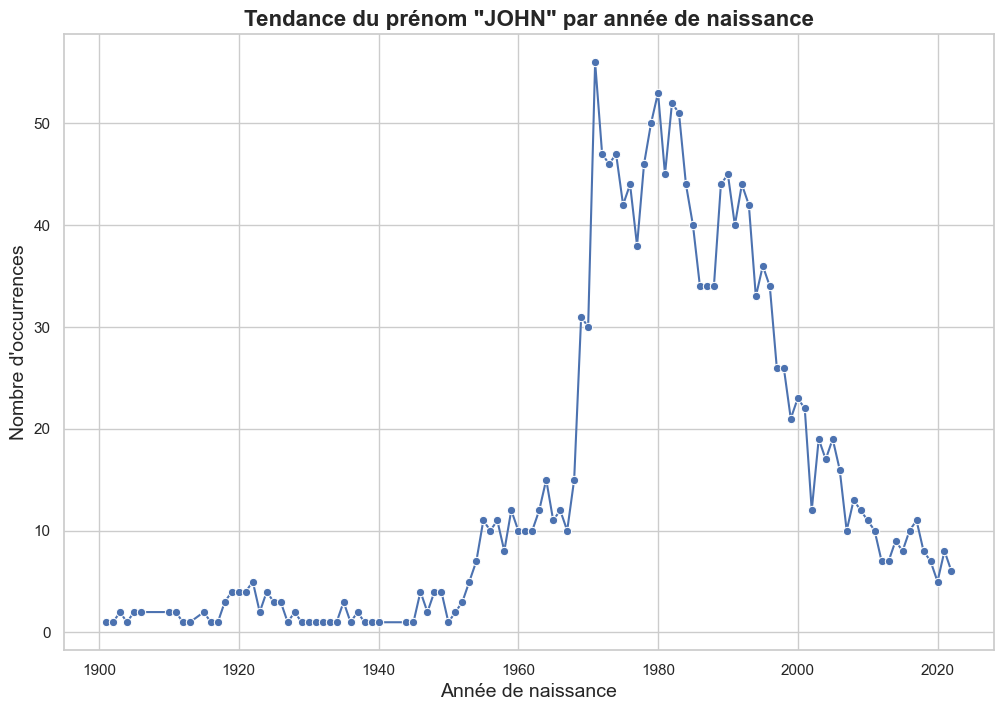

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

specific_name = 'JOHN'
filtered_data = data_dpt[data_dpt['preusuel'] == specific_name]

grouped_data = filtered_data.groupby('annais').size().reset_index(name='count')

sns.set(style='whitegrid')

plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='annais', y='count', data=grouped_data, marker='o')

plt.title(f'Tendance du prénom "{specific_name}" par année de naissance', fontsize=16, fontweight='bold')
plt.xlabel('Année de naissance', fontsize=14)
plt.ylabel('Nombre d\'occurrences', fontsize=14)
plt.savefig(f'tendance_prenom_{specific_name}.png')
plt.show()

# Nettoyage de données

In [22]:
# Enlever la colonne "nombre"
data_dpt = data_dpt.drop(columns = ["nombre"])
data_dpt.head(10)

,sexe,preusuel,annais,dpt,age,age_range
0,1,_PRENOMS_RARES,1900.0,02,125.0,80+
1,1,_PRENOMS_RARES,1900.0,04,125.0,80+
2,1,_PRENOMS_RARES,1900.0,05,125.0,80+
3,1,_PRENOMS_RARES,1900.0,06,125.0,80+
4,1,_PRENOMS_RARES,1900.0,07,125.0,80+
5,1,_PRENOMS_RARES,1900.0,08,125.0,80+
6,1,_PRENOMS_RARES,1900.0,09,125.0,80+
7,1,_PRENOMS_RARES,1900.0,10,125.0,80+
8,1,_PRENOMS_RARES,1900.0,11,125.0,80+
9,1,_PRENOMS_RARES,1900.0,12,125.0,80+


In [ ]:
# Données qui ne concerne pas "_PRENOMS_RARES" et département = XX
data_dpt = data_dpt[(data_dpt["preusuel"] != "_PRENOMS_RARES") & (data_dpt["dpt"] != "XX")]
data_dpt.head(10)

,sexe,preusuel,annais,dpt,age,age_range
11092,1,AADIL,1983.0,84,42.0,21-42
11093,1,AADIL,1992.0,92,33.0,21-42
11095,1,AAHIL,2016.0,95,9.0,0-20
11102,1,AARON,1962.0,75,63.0,43-65
11103,1,AARON,1976.0,75,49.0,43-65
11104,1,AARON,1982.0,75,43.0,43-65
11105,1,AARON,1984.0,75,41.0,21-42
11106,1,AARON,1985.0,75,40.0,21-42
11107,1,AARON,1989.0,75,36.0,21-42
11108,1,AARON,1990.0,69,35.0,21-42


In [24]:
# Valeurs uniques des colonnes
for c in data_dpt.columns:
  print(c)
  print(data_dpt[c].unique())

sexe
[1 2]
preusuel
['AADIL' 'AAHIL' 'AARON' ... 'ZUZANNA' 'ZYA' 'ZYNA']
annais
[1983. 1992. 2016. 1962. 1976. 1982. 1984. 1985. 1989. 1990. 1991. 1993.
 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2017. 2018.
 2019. 2020. 2021. 2022. 1955. 1961. 1960. 1963. 1965. 1968. 1969. 1972.
 1947. 1953. 1954. 1956. 1957. 1958. 1959. 1964. 1966. 1967. 1970. 1971.
 1973. 1974. 1975. 1977. 1979. 1980. 1981. 1986. 1951. 1952. 1948. 1978.
 1987. 1988. 1950. 1901. 1903. 1904. 1905. 1906. 1907. 1908. 1909. 1910.
 1911. 1912. 1913. 1914. 1915. 1916. 1917. 1918. 1919. 1920. 1921. 1922.
 1923. 1924. 1925. 1926. 1927. 1928. 1929. 1930. 1931. 1932. 1933. 1934.
 1935. 1936. 1937. 1938. 1939. 1940. 1941. 1942. 1943. 1944. 1945. 1946.
 1949. 1900. 1902.]
dpt
['84' '92' '95' '75' '69' '93' '67' '29' '76' '94' '971' '33' '91' '06'
 '11' '13' '31' '34' '18' '49' '59' '60' '77' '21' '44' '974' '68' '02'
 '03' '08' '12' '14' '

In [25]:
# Check les valeurs dupliquées
data_dpt.duplicated().sum()

0

In [26]:
# Check les valeurs manquantes
data_dpt.isnull().sum()

sexe         0
preusuel     0
annais       0
dpt          0
age          0
age_range    0
dtype: int64

# Encodage de la variable "dpt"

In [27]:
# Pour la varible "dpt"
import pickle
from sklearn.preprocessing import LabelEncoder
dpt_label_encoder = LabelEncoder()
data_dpt['dpt_encoded'] = dpt_label_encoder.fit_transform(data_dpt['dpt'])

with open('dpt_encoder.pkl', 'wb') as f:
    pickle.dump(dpt_label_encoder, f)

In [28]:
# Check type de données
data_dpt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773985 entries, 11092 to 3835764
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sexe         int64  
 1   preusuel     object 
 2   annais       float64
 3   dpt          object 
 4   age          float64
 5   age_range    object 
 6   dpt_encoded  int32  
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 215.9+ MB


In [29]:
data_dpt.head(10)

,sexe,preusuel,annais,dpt,age,age_range,dpt_encoded
11092,1,AADIL,1983.0,84,42.0,21-42,83
11093,1,AADIL,1992.0,92,33.0,21-42,91
11095,1,AAHIL,2016.0,95,9.0,0-20,94
11102,1,AARON,1962.0,75,63.0,43-65,74
11103,1,AARON,1976.0,75,49.0,43-65,74
11104,1,AARON,1982.0,75,43.0,43-65,74
11105,1,AARON,1984.0,75,41.0,21-42,74
11106,1,AARON,1985.0,75,40.0,21-42,74
11107,1,AARON,1989.0,75,36.0,21-42,74
11108,1,AARON,1990.0,69,35.0,21-42,68


# Normaliser les prénoms, enlever les accents

In [30]:
! pip install unidecode

In [31]:
from unidecode import unidecode

# Par exemple de "STÉPHANIE" vers "STEPHANIE"
def normalize_prename(prename):
  normalized_prename = unidecode(prename)
  normalized_prename = normalized_prename.upper()
  return normalized_prename


In [32]:
data_dpt["preusuel_normalized"] = data_dpt["preusuel"].apply(normalize_prename)
data_dpt.head(10)

,sexe,preusuel,annais,dpt,age,age_range,dpt_encoded,preusuel_normalized
11092,1,AADIL,1983.0,84,42.0,21-42,83,AADIL
11093,1,AADIL,1992.0,92,33.0,21-42,91,AADIL
11095,1,AAHIL,2016.0,95,9.0,0-20,94,AAHIL
11102,1,AARON,1962.0,75,63.0,43-65,74,AARON
11103,1,AARON,1976.0,75,49.0,43-65,74,AARON
11104,1,AARON,1982.0,75,43.0,43-65,74,AARON
11105,1,AARON,1984.0,75,41.0,21-42,74,AARON
11106,1,AARON,1985.0,75,40.0,21-42,74,AARON
11107,1,AARON,1989.0,75,36.0,21-42,74,AARON
11108,1,AARON,1990.0,69,35.0,21-42,68,AARON


In [33]:
data_dpt[data_dpt["preusuel_normalized"] == "THEO"]

,sexe,preusuel,annais,dpt,age,age_range,dpt_encoded,preusuel_normalized
1614915,1,THEO,2010.0,01,15.0,0-20,0,THEO
1614916,1,THEO,2010.0,02,15.0,0-20,1,THEO
1614917,1,THEO,2010.0,03,15.0,0-20,2,THEO
1614918,1,THEO,2010.0,04,15.0,0-20,3,THEO
1614919,1,THEO,2010.0,05,15.0,0-20,4,THEO
...,...,...,...,...,...,...,...,...
1618549,1,THÉO,2022.0,95,3.0,0-20,94,THEO
1618550,1,THÉO,2022.0,971,3.0,0-20,95,THEO
1618551,1,THÉO,2022.0,972,3.0,0-20,96,THEO
1618552,1,THÉO,2022.0,973,3.0,0-20,97,THEO


In [34]:
# Pour la variable "preusuel_normalized"
import pickle
from category_encoders import TargetEncoder
prenom_target_encoder = TargetEncoder()
data_dpt['preusuel_normalize_encoded'] = prenom_target_encoder.fit_transform(data_dpt['preusuel_normalized'], data_dpt['sexe'])

with open('prenom_encoder.pkl', 'wb') as f:
    pickle.dump(prenom_target_encoder, f)

In [35]:
data_dpt.head(10)

,sexe,preusuel,annais,dpt,age,age_range,dpt_encoded,preusuel_normalized,preusuel_normalize_encoded
11092,1,AADIL,1983.0,84,42.0,21-42,83,AADIL,1.459117
11093,1,AADIL,1992.0,92,33.0,21-42,91,AADIL,1.459117
11095,1,AAHIL,2016.0,95,9.0,0-20,94,AAHIL,1.465400
11102,1,AARON,1962.0,75,63.0,43-65,74,AARON,1.000000
11103,1,AARON,1976.0,75,49.0,43-65,74,AARON,1.000000
11104,1,AARON,1982.0,75,43.0,43-65,74,AARON,1.000000
11105,1,AARON,1984.0,75,41.0,21-42,74,AARON,1.000000
11106,1,AARON,1985.0,75,40.0,21-42,74,AARON,1.000000
11107,1,AARON,1989.0,75,36.0,21-42,74,AARON,1.000000
11108,1,AARON,1990.0,69,35.0,21-42,68,AARON,1.000000


# Préparation des données pour entraîner modèle ML

In [36]:
data_dpt_model = data_dpt.copy()
data_dpt_model = data_dpt_model[["sexe", "preusuel_normalize_encoded","age", "dpt_encoded","preusuel_normalized"]]
data_dpt_model.head(10)

,sexe,preusuel_normalize_encoded,age,dpt_encoded,preusuel_normalized
11092,1,1.459117,42.0,83,AADIL
11093,1,1.459117,33.0,91,AADIL
11095,1,1.465400,9.0,94,AAHIL
11102,1,1.000000,63.0,74,AARON
11103,1,1.000000,49.0,74,AARON
11104,1,1.000000,43.0,74,AARON
11105,1,1.000000,41.0,74,AARON
11106,1,1.000000,40.0,74,AARON
11107,1,1.000000,36.0,74,AARON
11108,1,1.000000,35.0,68,AARON


In [37]:
prename_mapping = (
    data_dpt_model[["preusuel_normalized", "preusuel_normalize_encoded"]]
    .drop_duplicates()
    .set_index("preusuel_normalized")["preusuel_normalize_encoded"]
    .to_dict()
)

print(prename_mapping)


{'AADIL': 1.459117189679729, 'AAHIL': 1.4653995783731404, 'AARON': 1.0, 'AARONN': 1.459117189679729, 'AARUSH': 1.437409499110285, 'AATHIRAN': 1.4653995783731404, 'AAYAN': 1.459117189679729, 'AB': 1.4653995783731404, 'AB-DEL': 1.4653995783731404, 'ABASS': 1.4291754000471546, 'ABBAS': 1.4291754000471546, 'ABBES': 1.4204285925317606, 'ABD': 1.0000073157145173, 'ABD-ALLAH': 1.4451371167876088, 'ABD-EL': 1.114580158165447, 'ABDALAH': 1.4523684821987526, 'ABDALLAH': 1.0, 'ABDARRAHMAN': 1.4653995783731404, 'ABDE': 1.4653995783731404, 'ABDEL': 1.0, 'ABDEL-AZIZ': 1.459117189679729, 'ABDEL-HAKIM': 1.3803642052082044, 'ABDEL-HALIM': 1.459117189679729, 'ABDEL-JALIL': 1.4653995783731404, 'ABDEL-KADER': 1.437409499110285, 'ABDEL-KARIM': 1.4291754000471546, 'ABDEL-KRIM': 1.459117189679729, 'ABDEL-MALEK': 1.4291754000471546, 'ABDEL-MALIK': 1.2675043753486037, 'ABDEL-NASSER': 1.4653995783731404, 'ABDEL-RAHIM': 1.4653995783731404, 'ABDEL-RAHMAN': 1.437409499110285, 'ABDEL-RAHMANE': 1.4653995783731404, '

In [38]:
import json

with open("prename_mapping.json", "w") as f:
    json.dump(prename_mapping, f)


In [39]:
data_dpt_model = data_dpt_model.drop(columns = ["preusuel_normalized"])
data_dpt_model.head(10)

,sexe,preusuel_normalize_encoded,age,dpt_encoded
11092,1,1.459117,42.0,83
11093,1,1.459117,33.0,91
11095,1,1.465400,9.0,94
11102,1,1.000000,63.0,74
11103,1,1.000000,49.0,74
11104,1,1.000000,43.0,74
11105,1,1.000000,41.0,74
11106,1,1.000000,40.0,74
11107,1,1.000000,36.0,74
11108,1,1.000000,35.0,68


In [41]:
# Exporter les données encodées concernant le sexe, prénom, départment et age
data_dpt_model.to_csv("data_dpt_model.csv", index = False)

# Utiliser les données nettoyées

In [39]:
data_dpt_model = pd.read_csv("data_dpt_model.csv")
# Diviser les données en 3 parties: entraînement (60%), validation (20%), test (20%)
train, val, test = np.split(data_dpt_model.sample(frac=1), [int(0.6*len(data_dpt_model)), int(0.8*len(data_dpt_model))])
print(len(train), len(val), len(test))

2264391 754797 754797


c:\Users\NSP-PC\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [40]:
import numpy as np
import tensorflow as tf

X_train, y_train = train.drop(columns=['sexe']), train['sexe'] - 1
X_val, y_val = val.drop(columns=['sexe']), val['sexe'] - 1
X_test, y_test = test.drop(columns=['sexe']), test['sexe'] - 1


In [41]:
X_train, X_val, X_test = X_train.astype('float32'), X_val.astype('float32'), X_test.astype('float32')

# Réseau de neurones

## Structure de réseau de neurones

In [42]:
! pip install tensorflow

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model_1f = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_1f.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


c:\Users\NSP-PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
model_1f.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,109 (27.77 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,740 (18.52 KB)

## L'entraînement du réseau de neurones

In [44]:
# Le modèle a été entraîné avec les prénoms en majuscule => sensitive case
# 21'53s
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_1f.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/5
70763/70763 ━━━━━━━━━━━━━━━━━━━━ 103s 1ms/step - accuracy: 0.6752 - loss: 0.7777 - val_accuracy: 0.9890 - val_loss: 0.0367
Epoch 2/5
70763/70763 ━━━━━━━━━━━━━━━━━━━━ 99s 1ms/step - accuracy: 0.9880 - loss: 0.0423 - val_accuracy: 0.9892 - val_loss: 0.0339
Epoch 3/5
70763/70763 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - accuracy: 0.9884 - loss: 0.0402 - val_accuracy: 0.9887 - val_loss: 0.0376
Epoch 4/5
70763/70763 ━━━━━━━━━━━━━━━━━━━━ 106s 1ms/step - accuracy: 0.9883 - loss: 0.0395 - val_accuracy: 0.9892 - val_loss: 0.0354
Epoch 5/5
70763/70763 ━━━━━━━━━━━━━━━━━━━━ 555s 8ms/step - accuracy: 0.9884 - loss: 0.0390 - val_accuracy: 0.9891 - val_loss: 0.0350


# Performance du modèle

## Graphiques de loss et accuracy sur les données de l'entraînement et de validation

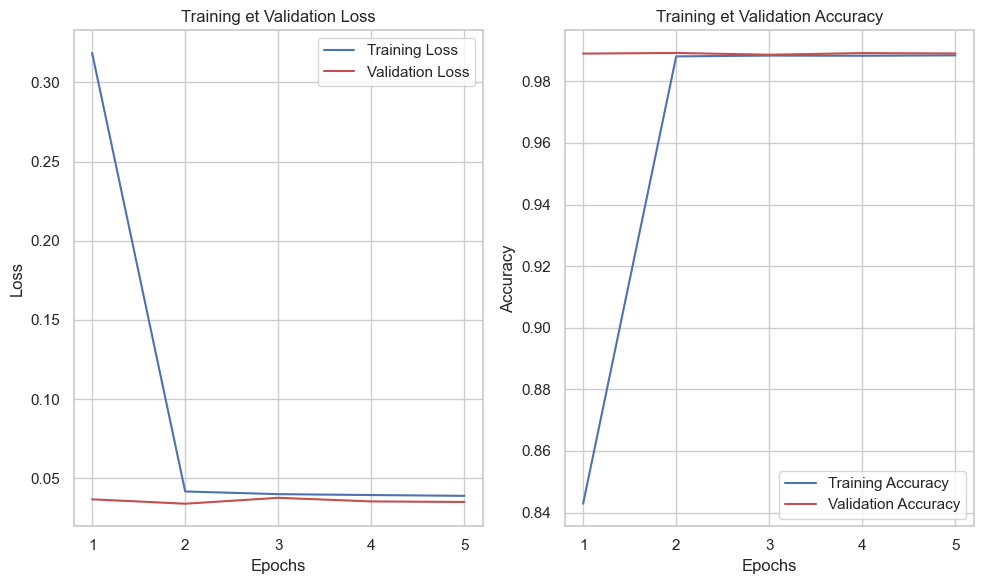

In [45]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title("Training et Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training et Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('loss_accuracy.png')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
test_loss, test_accuracy = model_1f.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

23588/23588 ━━━━━━━━━━━━━━━━━━━━ 18s 749us/step - accuracy: 0.9893 - loss: 0.0338
Test Loss: 0.034169670194387436
Test Accuracy: 0.9891865253448486


23588/23588 ━━━━━━━━━━━━━━━━━━━━ 18s 770us/step


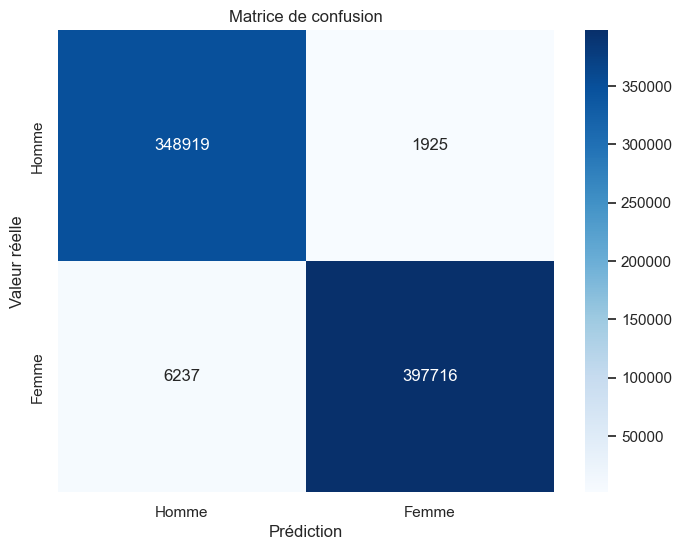

In [47]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_1 = model_1f.predict(X_test)
y_pred_classes = (y_pred_1 > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Homme', 'Femme'], yticklabels=['Homme', 'Femme'])
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Valeur réelle')
plt.savefig('confusion_matrix.png')
plt.show()

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
TN, FP, FN, TP = cm.ravel()
print(f"True Positive (TP): {TP}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Negative (TN): {TN}")

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Rappel: {recall}")
print(f"F1 Score: {f1}")

True Positive (TP): 397716
False Positive (FP): 1925
False Negative (FN): 6237
True Negative (TN): 348919
Accuracy: 0.9891864965017084
Precision: 0.9951831769012689
Rappel: 0.9845600849603791
F1 Score: 0.9898431297396446


#### Interprétation
Matrice de Confusion :
- Vrai Positif (TP) : 397 716 – Ce sont les instances où le modèle a correctement prédit la classe "Homme" (c'est-à-dire que la valeur réelle était "Homme", et le modèle l'a prédite comme étant "Homme").
- Faux Positif (FP) : 1 925 – Ce sont les instances où le modèle a incorrectement prédit "Homme" alors que la valeur réelle était "Femme".
- Faux Négatif (FN) : 6 237 – Ce sont les instances où le modèle a incorrectement prédit "Femme" alors que la valeur réelle était "Homme".
- Vrai Négatif (TN) : 348 919 – Ce sont les instances où le modèle a correctement prédit la classe "Femme" (c'est-à-dire que la valeur réelle était "Femme", et le modèle l'a prédite comme étant "Femme").

Métriques :
- Précision (Accuracy - 0.9892)
La précision mesure la proportion globale des prédictions correctes (à la fois les vrais positifs et les vrais négatifs) sur l'ensemble des prédictions.
Une précision de 98,92% indique que le modèle fonctionne très bien pour distinguer entre les hommes et les femmes. Le modèle a correctement prédit environ 99 % des cas.

- Précision (Precision - 0.9952)
La précision est la proportion des prédictions positives correctes (Vrais Positifs) sur toutes les prédictions positives (Vrais Positifs + Faux Positifs).
Cette précision élevée signifie que lorsque le modèle prédit "Homme", il est très probable qu'il ait raison, avec un nombre très faible de faux positifs.

- Rappel (Recall - 0.9846)
Le rappel est la proportion des prédictions positives correctes (Vrais Positifs) sur toutes les instances positives réelles (Vrais Positifs + Faux Négatifs).
Un rappel de 98,46 % signifie que le modèle identifie correctement presque tous les cas réels de "Homme", mais qu'il en manque encore quelques-uns (faux négatifs).

- Score F1 : 0.9898 (98.98%)
Le score F1 est la moyenne harmonique de la précision et du rappel, fournissant un équilibre entre les deux. Plus le score F1 est élevé, mieux l'équilibre entre la précision et le rappel est maintenu.
Avec un score F1 de 98,98 %, le modèle montre une bonne performance, garantissant que la précision et le rappel sont élevés.

## La courbe ROC

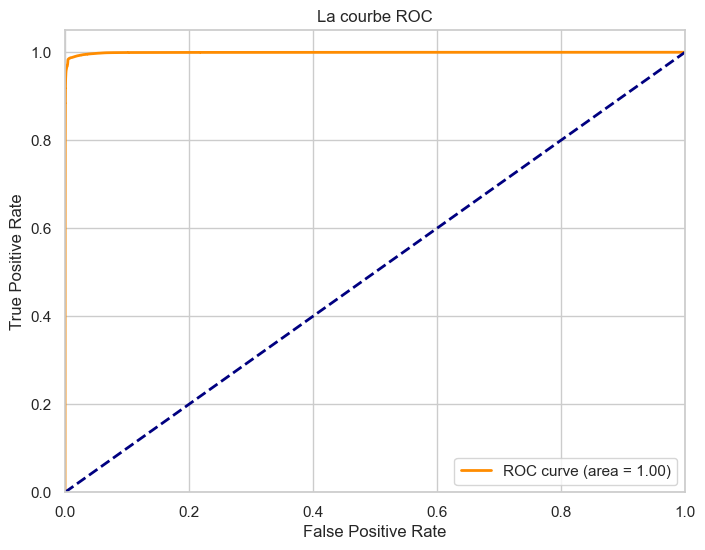

In [60]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('La courbe ROC')
plt.legend(loc="best")
plt.savefig('roc_curve.png')

In [173]:
print(f"Area under the ROC curve: {roc_auc}")

Area under the ROC curve: 0.9991322012929235


#### Interprétation : 
- La courbe ROC représente deux métriques : 
    + Taux de Vrai Positifs (TPR) : La proportion des positifs réels ("Homme") qui ont été correctement identifiés par le modèle. 
    + Taux de Faux Positifs (FPR) : La proportion des négatifs réels ("Femme") qui ont été incorrectement identifiés comme positifs par le modèle.
- Dans ce cas, AUC = 0.9991322012929235
    + Pour n'importe quel seuil, le modèle distingue correctement entre les deux classes avec une grande certitude.
    + La courbe est très proche du coin supérieur gauche, ce qui signifie que les deux métriques sont favorables.



## Classification report

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    350844
           1       1.00      0.98      0.99    403953

    accuracy                           0.99    754797
   macro avg       0.99      0.99      0.99    754797
weighted avg       0.99      0.99      0.99    754797



# Tester la prédiction

## La fonction de prédiction

In [ ]:
from difflib import get_close_matches

def predict_sex(prenom, annais, department):
    prenom = normalize_prename(prenom)
    mapping_dict = prenom_target_encoder.ordinal_encoder.category_mapping[0]['mapping']

    mapping_dict = {str(k): v for k, v in mapping_dict.items()}

    if prenom in mapping_dict:
        prenom_encoded = mapping_dict[prenom]
    else:
        close_matches = get_close_matches(prenom, mapping_dict.keys(), n=3, cutoff=0.6)
        suggestions = f"Liste des prénoms similaires ou proches: {', '.join(close_matches)}?" if close_matches else ""
        return f"Sex prédit: Invalid - Probabilité : 0. {suggestions}"

    prenom_df = pd.DataFrame([prenom], columns=['preusuel_normalized'])
    prenom_encoded = prenom_target_encoder.transform(prenom_df)['preusuel_normalized'].values[0]
    department_encoded = dpt_label_encoder.transform([department])[0]
    input_data = np.array([[prenom_encoded, current_year - annais, department_encoded]])

    input_data_df = pd.DataFrame(input_data, columns=["preusuel_normalize_encoded", "age", "dpt_encoded"])

    prediction = model_1f.predict(input_data_df)

    femme_prob = prediction[0][0]
    homme_prob = 1 - femme_prob

    if femme_prob > homme_prob:
        sex_predit = "Femme"
        prob = femme_prob*100
    else:
        sex_predit = "Homme"
        prob = homme_prob*100

    # return f"{sex_predit} - Probabilité : {prob:.2f}%"
    return f"{sex_predit}"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sexe prédite: Femme


## Tester le modèle manuellement:

In [ ]:
# Taper le prénom que vous voulez prédire
prenom = "PHILOMENE" 
annais = 1990
department = "06"

sex_pred = predict_sex(prenom, annais, department)
print(f"Sexe prédite: {sex_pred}")

## Vérification par la distribution du prénom en fonction de sexe

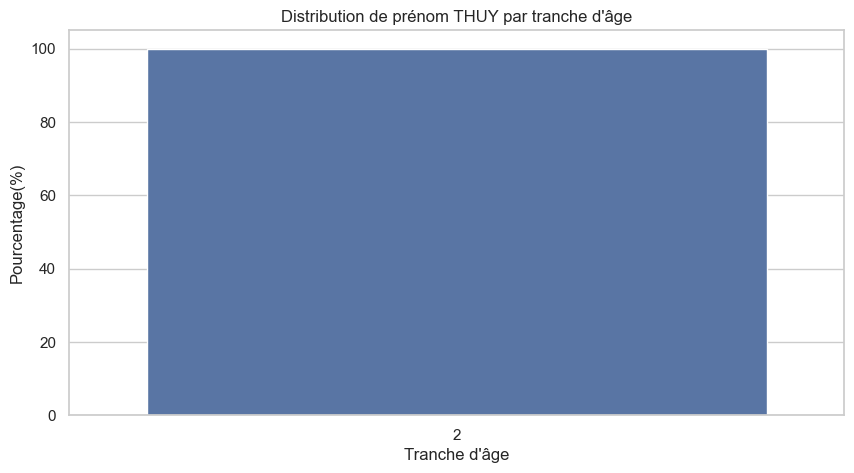

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

prename = "John" # Taper le prénom que vous voulez visualiser
prename = normalize_prename(prename)
data_dpt_prename = data_dpt[data_dpt["preusuel_normalized"] == prename]

plt.figure(figsize = (10, 5))
sns.countplot(x='sexe', data = data_dpt_prename, order=data_dpt_prename['sexe'].value_counts().index, stat = "percent")
plt.title(f"Distribution de prénom {prename} par tranche d'âge\n Homme(1) vs Femme(2)")
plt.xlabel('Tranche d\'âge')
plt.ylabel('Pourcentage(%)')
plt.savefig(f"dist_{prename}_tranche_age.png")
plt.show()

# XAI avec SHAP

In [51]:
! pip install shap

## Diagramme en barre de niveau d'importance des features sur toutes les données d'entraînement (à voir et pas à exécuter)

ExactExplainer explainer: 2264392it [6:39:50, 94.36it/s]                                  


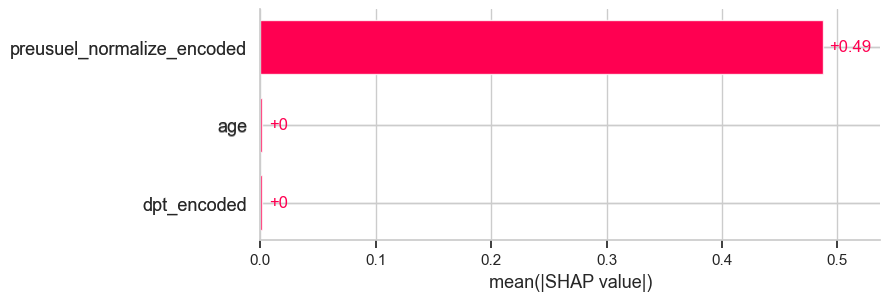

In [71]:
import shap
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# explainer_bar = shap.Explainer(model_1f, X_train)
# shap_values_bar = explainer_bar(X_train)

# shap.plots.bar(shap_values_bar)


#### Commentaire 
Description générale :
- Le graphique est un graphique à barres généré à partir des valeurs SHAP (SHapley Additive exPlanations). Les valeurs SHAP mesurent l'importance de chaque caractéristique pour la prédiction d'un modèle. Plus précisément, elles indiquent la contribution de chaque variable dans la prédiction, que ce soit de manière positive ou négative.

Interprétation du graphique :
a) Axe des ordonnées (Y) :
- Trois variables sont affichées :
    + preusuel_normalize_encoded (le prénom normalisé et encodé),
    + age (l'âge),
    + dpt_encoded (le département encodé).

b) Axe des abscisses (X) :
- Le titre de l'axe des abscisses est "mean(|SHAP value|)", ce qui signifie la moyenne des valeurs absolues des valeurs SHAP pour chaque variable.
- L'échelle varie de 0 à 0.5, et elle représente l'importance moyenne de chaque variable dans la prise de décision du modèle.

Analyse des barres :
- preusuel_normalize_encoded : Cette variable a une barre avec un SHAP value moyen de +0.49. Cela signifie que le prénom encodé a une contribution relativement importante dans les prédictions du modèle, et sa présence ou absence influence fortement la décision du modèle.
- age : La barre pour l'âge montre un SHAP value de +0, ce qui suggère que l'âge n'a pas d'impact significatif sur les prédictions du modèle. Cette variable semble être relativement neutre par rapport à l'impact qu'elle a sur le modèle.
- dpt_encoded : De même, pour le département encodé, la barre montre un SHAP value de +0, indiquant qu'elle n'a pas non plus un impact notable sur les prédictions.

In [117]:
# Explainer sur un échantillon de données de 100 premières individus
explainer_model = shap.Explainer(model_1f, X_train)
shap_values_sample = explainer_model(X_train[0:100])

In [195]:
# Infos détaillées pour un individu spécifique dans 100 individus prédéfinis:
instance_index = 35  
encoded_value_35 = X_train[0:100].iloc[instance_index]["preusuel_normalize_encoded"]

def find_closest_prename(encoded_value, mapping, tolerance=0.01):
    closest_prename = None
    closest_diff = float("inf")
    
    for prename, value in mapping.items():
        diff = abs(value - encoded_value)
        if diff < closest_diff and diff <= tolerance:
            closest_diff = diff
            closest_prename = prename
    return closest_prename

closest_prename_35 = find_closest_prename(encoded_value_35, prename_mapping)

person_details = X_train[0:100].iloc[instance_index]

print("Infos détaillées pour shap_values_sample[35]:")
print(person_details)

if closest_prename_35:
    print(f"\nPrénom encodé (à partir de l'échantillon): {encoded_value_35}")
    print(f"La valeur d'encodage la plus proche (la recherche mapping): {prename_mapping[closest_prename_35]}")
    print(f"Le prénom concerné: {closest_prename_35}")
else:
    print(f"\nPrénom non trouvé pour la valeu d'encodage: {encoded_value_35}.")

Infos détaillées pour shap_values_sample[35]:
preusuel_normalize_encoded      1.992565
age                           116.000000
dpt_encoded                    61.000000
Name: 3508771, dtype: float32

Prénom encodé (à partir de l'échantillon): 1.9925650358200073
La valeur d'encodage la plus proche (la recherche mapping): 1.9925650557620818
Le prénom concerné: PHILOMENE


In [212]:
prenom = "Michol"
annais = 2000
department = "06"

sex_pred = predict_sex(prenom, annais, department)
print(f"Sexe prédite: {sex_pred}")

Sexe prédite: Sex prédit: Invalid - Probabilité : 0. Liste des prénoms similaires ou proches: MICHEL, MICHAL, MITCHEL?


## Waterfall plot

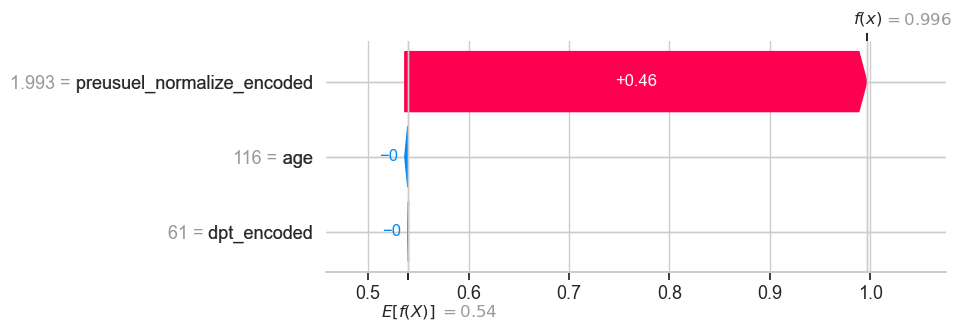

In [186]:
# Waterfall plot pour un instance
shap.plots.waterfall(shap_values_sample[35])
# shap.plots.waterfall(shap_values_sample[0])

#### Commentaire
Description générale :
- Le graphique waterfall (ou en cascade) est utilisé pour visualiser l'impact de chaque caractéristique sur la prédiction d'un modèle. Ce type de graphique permet de voir de manière détaillée comment chaque variable contribue à la prédiction, à partir de la prédiction de base (moyenne des prédictions) jusqu'à la prédiction finale pour un exemple spécifique.

Interprétation du graphique :
a) Axe des ordonnées (Y) :
- L'axe des ordonnées montre trois variables comme précédemment :
    + preusuel_normalize_encoded (prénom encodé, le numéro 1.004 est la valeur actuelle de l'instant concerné),
    + dpt_encoded (département encodé avec la valeur actuelle de 39),
    + age (l'âge actuelle égale à 51).

- Axe des abscisses (X) :
    + L'axe des abscisses représente la valeur de contribution de chaque variable au score final. L'échelle varie de 0 à 0.6.
    + La notion "E[f(X)] = 0.54" représente la valeur prédite moyenne par le modèle pour toutes les observations, c'est-à-dire la prédiction de base.

Comprendre les barres :
- 1.004 = preusuel_normalize_encoded : La barre montre une valeur de -0.54. Cela signifie que le prénom encodé a une influence négative de -0.54 sur la prédiction de cet exemple particulier. Cette variable a réduit la prédiction initiale du modèle (qui était de 0.54) de 0.54.
- 39 = dpt_encoded : La barre montre une valeur de -0, indiquant que le département encodé n'a pas d'impact significatif sur la prédiction pour cet exemple particulier. Cette variable n'a pas contribué ou modifié la prédiction.
- 51 = age : La barre montre une valeur de +0, indiquant que l'âge n'a pas non plus influencé la prédiction pour cet exemple particulier.
- Ligne verticale grise (f(x) = 0.002) :
Cette ligne verticale grise indique la prédiction finale pour cet exemple spécifique. La valeur f(x) = 0.002 représente la prédiction que le modèle a faite pour cet exemple, après avoir pris en compte l'impact des différentes variables. Cette valeur est très proche de 0, ce qui indique que la prédiction finale est proche de la frontière de décision entre les deux classes (par exemple, "Homme" et "Femme").

## Beeswarm plot

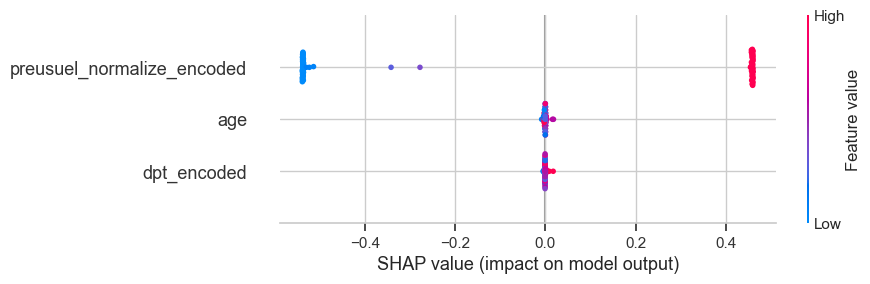

In [132]:
# bee swarm plot
shap.plots.beeswarm(shap_values_sample)

## Diagramme en barre concernant l'importance des features en fontion du sexe

In [82]:
X_train_sample = X_train.sample(n=100, random_state=42)
explainer_sample = shap.Explainer(model_1f, X_train_sample)
shap_values_sample = explainer_sample(X_train_sample)
sexe_sample = ["Women" if data_dpt_model.loc[idx, "sexe"] == 2 else "Men" for idx in X_train_sample.index]

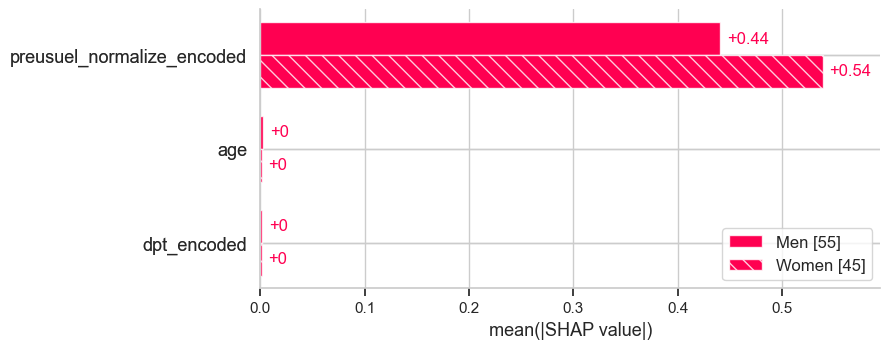

In [86]:
shap_values_cohorts = shap_values_sample.cohorts(sexe_sample)
mean_abs_shap_values = shap_values_cohorts.abs.mean(0)
shap.plots.bar(mean_abs_shap_values)

#### Commentaire
Ces valeurs "+0.54" et "+0.44" représentent l'impact moyen absolu de la variable preusuel_normalize_encoded sur les prédictions du modèle, pour les deux groupes de sexe (Men et Women). Voici ce que cela signifie :

+0.54 pour les femmes :
Cela indique que, en moyenne, la variable preusuel_normalize_encoded contribue à augmenter la probabilité que le modèle prévoie "Femme" avec une intensité de 0.54 (en termes de SHAP value absolue). En d'autres termes, c'est la variable qui influence le plus la prédiction du modèle pour ce groupe.

+0.44 pour les hommes :
De la même manière, pour le groupe des hommes, la variable preusuel_normalize_encoded contribue à augmenter la probabilité que le modèle prévoie "Homme" avec une intensité moyenne de 0.44.

Comparaison entre les deux valeurs :
La contribution de la variable preusuel_normalize_encoded est plus importante pour prédire qu'une personne est une femme (0.54) que pour prédire qu'une personne est un homme (0.44).

Cela signifie que le prénom encodé (représenté par preusuel_normalize_encoded) joue un rôle plus déterminant dans les prédictions pour le genre féminin que pour le genre masculin.

## Diagramme de décision concernant un individu

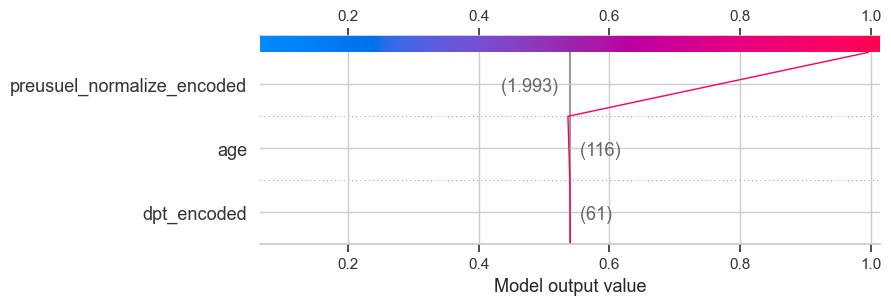

In [194]:
observation_idx = 35
observation = X_train[0:100].iloc[observation_idx]

shap.decision_plot(
    base_value = shap_values_sample.base_values[observation_idx],
    shap_values=shap_values_sample.values[observation_idx], 
    features=observation.values,  
    feature_names=X_train_sample.columns.tolist(),  
)

In [42]:
with open("prename_mapping.json", "r") as f:
    prename_mapping = json.load(f)

# Example usage
prenom_test = "MORGAN"
prenom_test = normalize_prename(prenom_test)
if prenom_test in prename_mapping:
    prenom_test_encoded = prename_mapping[prenom_test]
    print(f"Valeur encodée pour le prénom '{prenom_test}': {prenom_test_encoded}")
else:
    print(f"Prénom '{prenom_test}' n'existe pas dans le mapping.")


Valeur encodée pour le prénom 'MORGAN': 1.0798050563508985
